

# Objective

Investigate the effect of lockdown measures on economy. To identify economic activity we consider data sets such as electricity consumption and heavy truck toll movement data. As trucks are mainly used to transport goods their movement data helps in estimating the current economic activity

**Assumptions:**

* We consider all data specific to Germany/Berlin

* We consider electricity consumption data as a proxy indicator of economic activity


**Data used**

* Oxford Stringency Index - https://github.com/OxCGRT/covid-policy-tracker

* Apple Transit mobility - https://covid19.apple.com/mobility

* Berlin air temperature - https://mesonet.agron.iastate.edu/ASOS/

* Electricity consumption - Actual load data - https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show

* Truck toll data - Germany - https://www.destatis.de/DE/Themen/Branchen-Unternehmen/Industrie-Verarbeitendes-Gewerbe/Tabellen/Lkw-Maut-Fahrleistungsindex-Daten.xlsx?__blob=publicationFile


**Steps taken**

* Prepare the dataset. Consolidate above mentioned data into a single dataframe

* Build a causal model to estimate the effect of stringency measures on energy consumption

* Build a causal model to estimate the effect of stringency measures on truck toll movement

In [1]:
from project_lib import Project
from sqlalchemy import create_engine
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from functools import reduce
import requests
import io
import seaborn as sbs
import datetime

try:
    import graphviz
except:
    !pip install graphviz
    import graphviz
try:
    import pydotplus
except:
    !pip install pydotplus
    
from IPython.display import display

import networkx as nx
try:
    import pydot
except:
    !pip install pydot

try:
    from dowhy import CausalModel
except:
    #!pip install sympy
    !pip install -I dowhy
    from dowhy import CausalModel
    
import warnings
warnings.filterwarnings('ignore')


plt.style.use('ggplot')
%matplotlib inline

**Data Preparation**

In [2]:
project = Project.access()
Emergent_Db2_Warehouse_credentials = project.get_connection(name="db2 Warehouse ealuser")

sqla_url= "db2+ibm_db://" + Emergent_Db2_Warehouse_credentials['username']+ ':' + Emergent_Db2_Warehouse_credentials['password'] + "@"+ Emergent_Db2_Warehouse_credentials['host'] + ":50001/BLUDB;Security=ssl;"

#sqlalchemy
engine = create_engine(sqla_url, pool_size=10, max_overflow=20)
conn = engine.connect()
#engine.table_names()

Clustering of power consumption data:
    
    We have the power consumption data with a frequency of 1 hour for the year 2020. Using the raw data might be overwhelming for the causal model and the model might fail to identify the pattern in power consumption. So we cluster the data and use the cluster centers for the causal analysis.
    
    From the silhouette score plot, we see that the Kmeans with 3 clusters has the highest score suggesting an industrial pattern in power consumption

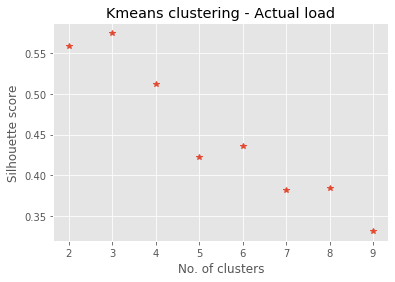

In [7]:
# Apple Transit mobility
df_apple_mob = pd.read_sql('select * from apple_transit_mobility;',conn)
df_apple_mob.index = pd.to_datetime(df_apple_mob['Timestamp'])
df_apple_mob_de = df_apple_mob[df_apple_mob['region']=='Berlin']

# Oxford Stringency index
df_stringency = pd.read_sql('select * from oxford_stringency_index',conn)
df_stringency_de = df_stringency[df_stringency['countryname']=='Germany']
df_stringency_de.index = pd.to_datetime(df_stringency_de['date'].astype(str))

# Berlin air temperature
r=requests.get('https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=EDDB&data=tmpc&year1=2020&month1=1&day1=1&year2=2020&month2=12&day2=7&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2')
df_airtemp_be = pd.read_csv(io.BytesIO(r.content))
df_airtemp_be.index = pd.to_datetime(df_airtemp_be['valid'].values)
df_airtemp_be.drop(['station','valid'],axis=1,inplace=True)
df_airtemp_be = df_airtemp_be.resample('1D').median()

# Electricity consumption - Actual load data Germany
df_energy = pd.read_sql('select * from power_consumption', conn)
df_energy.index = pd.to_datetime(df_energy['load_date'].values)
df_energy.drop(['load_date','country'],axis=1,inplace=True)

#Energy consumption as it corresponds to human activity should show some sort of clustering behaviour.
# Consider the energy consumption data only until end of October 2020
df_energy_2020 = df_energy[(df_energy.index>pd.to_datetime('2019-12-31'))&(df_energy.index<pd.to_datetime('2020-11-1'))]

_X = df_energy_2020.replace(np.nan,0).values
scores = []
for n in range(2,10):
    res = KMeans(n).fit_predict(_X)
    scores.append(silhouette_score(_X,res))
plt.plot(range(2,10),scores,'*')
plt.title("Kmeans clustering - Actual load")
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette score')
plt.show()

# Use the 3 cluster centres as a representative of actual load data
clusterer_ = KMeans(3,random_state=42)
clusterer_.fit(_X)
_res = clusterer_.transform(_X)
df_energy_2020_fitted = pd.DataFrame(_res)
df_energy_2020_fitted.index = df_energy_2020.index
df_energy_2020_fitted.columns = ['energycc1','energycc2','energycc3']

# Truck toll data
df_lkw_movement = pd.read_excel("https://www.destatis.de/DE/Themen/Branchen-Unternehmen/Industrie-Verarbeitendes-Gewerbe/Tabellen/Lkw-Maut-Fahrleistungsindex-Daten.xlsx?__blob=publicationFile"
                       ,sheet_name="Daten",skiprows=5)
df_lkw_movement.index = pd.to_datetime(df_lkw_movement['Datum'])
df_lkw_movement.drop(['Datum'],axis=1,inplace=True)
df_lkw_movement_2020 = df_lkw_movement[df_lkw_movement.index>pd.to_datetime('2019-12-31')]
df_lkw_movement_2020.rename({'unbereinigt':'Truck_toll_movement_raw','Kalender- und saisonbereinigt (KSB)':'Truck_toll_movement_season_adj'},axis=1,inplace=True)

dfs = [df_apple_mob_de,df_stringency_de,df_airtemp_be,df_energy_2020_fitted,df_lkw_movement_2020]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs)
df_final['weekday']=df_final.index.dayofweek.values



We would like to estimate feature importances towards KMeans clustering. Fit a model, we use decision tree to the transformed data with the labels identified by KMeans algorithm. 

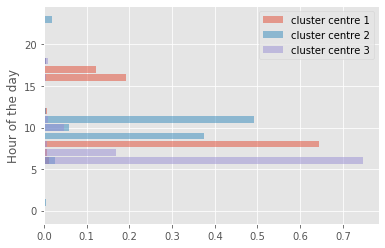

In [8]:
from sklearn.tree import DecisionTreeRegressor
clf_tree = DecisionTreeRegressor(random_state=42)
clf_tree.fit(_X,_res[:,0])
plt.barh(range(24),clf_tree.feature_importances_,alpha=0.5)
clf_tree = DecisionTreeRegressor(random_state=42)
clf_tree.fit(_X,_res[:,1])
plt.barh(range(24),clf_tree.feature_importances_,alpha=0.5)
clf_tree = DecisionTreeRegressor(random_state=42)
clf_tree.fit(_X,_res[:,2])
plt.barh(range(24),clf_tree.feature_importances_,alpha=0.5)
plt.legend(['cluster centre 1','cluster centre 2','cluster centre 3'])
plt.ylabel('Hour of the day');

What the above graph indicates is the following

- the energy cluster 1 corresponds to consumption pattern at 08:00, 16:00, 17:00
- the energy cluster 2 corresponds to consumption pattern at 10:00 - 11:00
- the energy cluster 3 corresponds to consumption pattern at 06:00 - 07:00 
            
As the latter intuitively indicates "peak load" / "rush hour load", we are primarily interested in assessing the impact of lockdown on the same

The raw time-series nature of the data is flattened out to individual non-sequential records by including additional seasonal indicator columns such as is_weekend, is_winter, is_spring, is_summer, is_autumn.

Reference: https://github.com/microsoft/dowhy/issues/174

In [9]:
df_final['is_weekend'] = np.where((df_final.index.weekday == 5)|(df_final.index.weekday == 6),1,0)
df_final['is_winter'] = np.where((df_final.index.month==12)|(df_final.index.month<=2),1,0)
df_final['is_spring'] = np.where((df_final.index.month>=3)&(df_final.index.month<=5),1,0)
df_final['is_summer'] = np.where((df_final.index.month>=6)&(df_final.index.month<=8),1,0)
df_final['is_autumn'] = np.where((df_final.index.month>=9)&(df_final.index.month<=11),1,0)
#df_final['mobility_1'] = df_final['mobility'].shift()
#df_final['stringency_1'] = df_final['stringencyindex'].shift()

In [10]:
df_final = df_final[df_final.index<datetime.datetime(2020,11,1)]

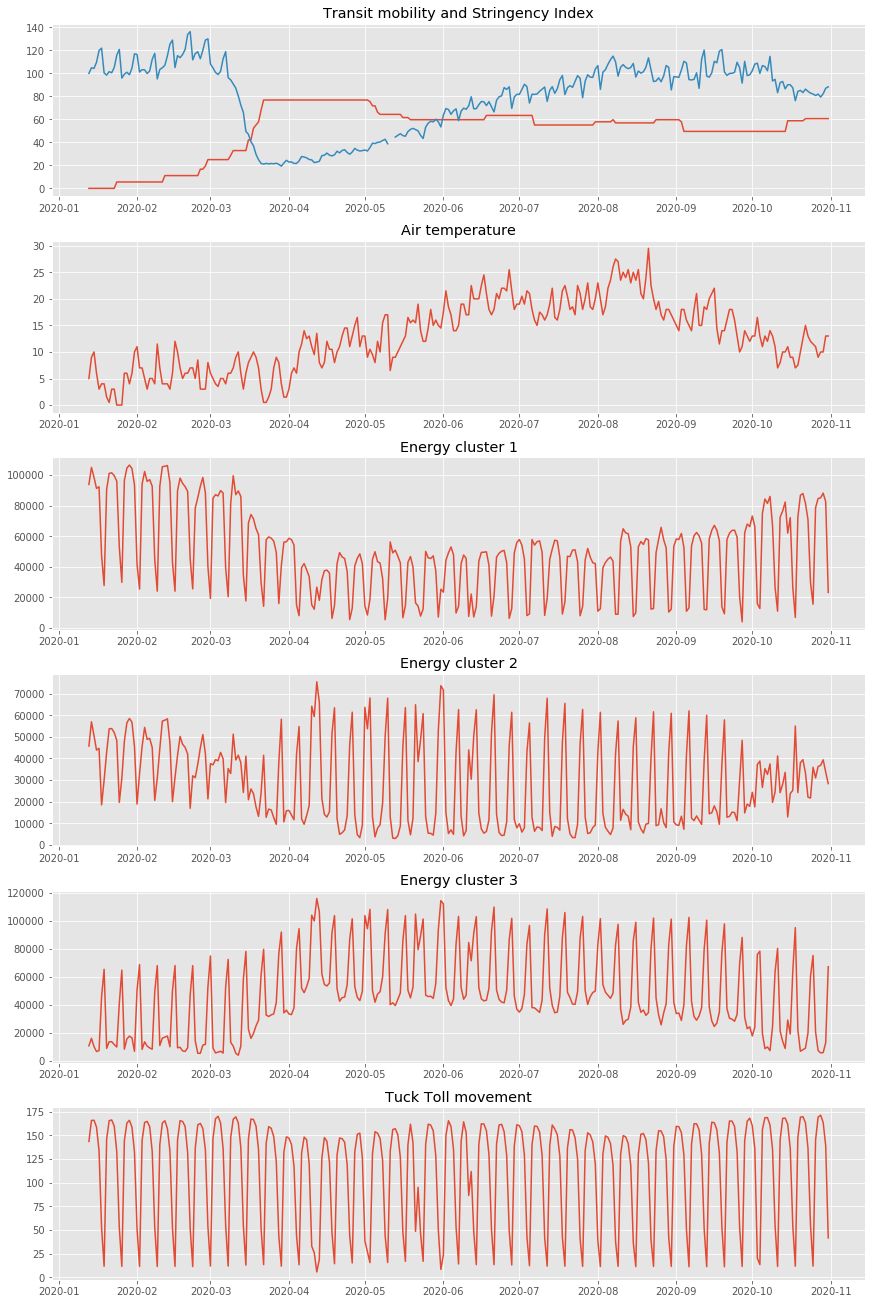

In [11]:
fig,axs = plt.subplots(nrows=6,ncols=1,figsize=(12,18),constrained_layout=True)
axs[0].plot(df_final['stringencyindex'])
axs[0].plot(df_final['mobility'])
axs[0].set_title("Transit mobility and Stringency Index")
axs[1].plot(df_final['tmpc'])
axs[1].set_title("Air temperature")
axs[2].plot(df_final['energycc1'])
axs[2].set_title("Energy cluster 1")
axs[3].plot(df_final['energycc2'])
axs[3].set_title("Energy cluster 2")
axs[4].plot(df_final['energycc3'])
axs[4].set_title("Energy cluster 3")
axs[5].plot(df_final['Truck_toll_movement_raw'])
axs[5].set_title("Tuck Toll movement")
plt.show()

In [12]:
df_final.tail()

,Timestamp,mobility,region,countryname,countrycode,regionname,regioncode,jurisdiction,date,c1_school closing,...,Truck_toll_movement_raw,Truck_toll_movement_season_adj,gleitender 7-Tage-Durchschnitt KSB,Veränderung KSB gegenüber Vortag in Prozent,weekday,is_weekend,is_winter,is_spring,is_summer,is_autumn
2020-10-27,2020-10-27,82.00,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201027,1.0,...,169.2,113.4,114.4,1.8,1,0,0,0,0,1
2020-10-28,2020-10-28,79.45,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201028,1.0,...,171.1,113.0,116.2,-0.4,2,0,0,0,0,1
2020-10-29,2020-10-29,82.26,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201029,1.0,...,163.5,113.5,118.5,0.4,3,0,0,0,0,1
2020-10-30,2020-10-30,87.06,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201030,1.0,...,138.8,121.8,119.4,7.3,4,0,0,0,0,1
2020-10-31,2020-10-31,88.29,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201031,1.0,...,41.6,126.6,119.5,3.9,5,1,0,0,0,1


In [13]:
df_final.to_csv("/project_data/data_asset/dowhy_economic_data.csv")

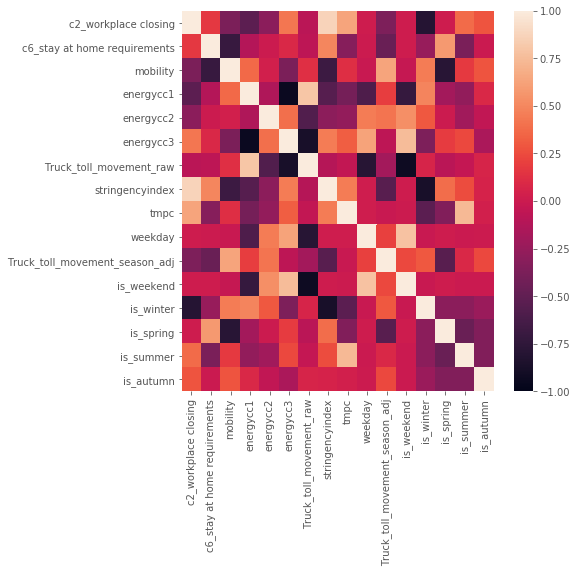

In [14]:
df_final_de_corr = df_final[['c2_workplace closing','c6_stay at home requirements','mobility','energycc1','energycc2','energycc3','Truck_toll_movement_raw','stringencyindex','tmpc',
                             'weekday','Truck_toll_movement_season_adj','is_weekend','is_winter','is_spring','is_summer','is_autumn']].corr()

#df_final_de_corr
plt.figure(figsize=(7,7))
sbs.heatmap(df_final_de_corr, vmax=1,vmin=-1)
plt.show()

**Hypothesis testing**

#### Hypothesis I

Estimate the effect of stringency measures on energycluster1

Consider Stringencyindex, Energy clusters, toll data corrected for seasonal effects, air temperature

**Determining edges mainly using linear correlation metrics**

mobility --> energycc1
mobility --> energycc3
stringencyindex --> mobility
stringencyindex --> energycc1
stringencyindex --> energycc3
tmpc --> energycc1
tmpc --> energycc3
is_weekend --> energycc1
is_weekend --> energycc2
is_weekend --> energycc3
is_weekend --> Truck_toll_movement_raw
is_spring --> mobility


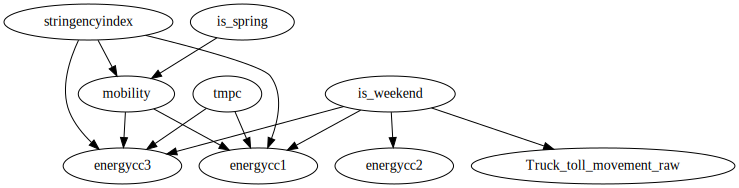

In [15]:
node_names = df_final_de_corr.columns
causes = ['mobility','stringencyindex','tmpc','is_weekend','is_spring','is_summer','is_autumn']
effects = ['mobility','energycc1', 'energycc2', 'energycc3','Truck_toll_movement_raw']
corr_graph_filename='prunedcausal-raw_extendedfeats_corr.dot'

corr_causal_graph = nx.DiGraph()    
corr_causal_graph.add_nodes_from(node_names)

used_nodes = []
for _node1 in causes:
    for _node2 in effects:
        if _node1 != _node2:
            if (abs(df_final_de_corr[_node1][_node2])>0.3):# & ([_node2,_node1] not in causal_graph.edges):
                print(_node1,'-->',_node2)
                corr_causal_graph.add_edge(_node1,_node2)
                used_nodes.extend([_node1,_node2])

used_nodes_set = set(used_nodes)
unused_nodes = list(set(node_names).difference(set(used_nodes_set)))

corr_causal_graph.remove_nodes_from(unused_nodes)
#causal_graph.add_edge("U",'stringencyindex')
#causal_graph.add_edge("U","energycc3")

nx.drawing.nx_pydot.write_dot(corr_causal_graph,corr_graph_filename)

with open(corr_graph_filename) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


**Combining the results from correlation analysis and domain knowledge**

* We consider only one of the energy clusters

* Seasonal effect is taken into consideration

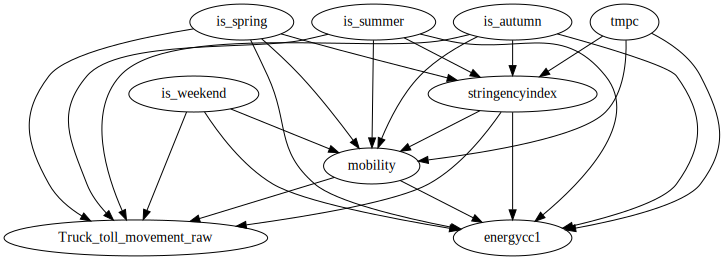

In [17]:
combined_causal_graph = nx.DiGraph()
combined_causal_graph.add_edge('is_weekend','mobility')
#combined_causal_graph.add_edge('is_winter','mobility')
combined_causal_graph.add_edge('is_spring','mobility')
combined_causal_graph.add_edge('is_summer','mobility')
combined_causal_graph.add_edge('is_autumn','mobility')
combined_causal_graph.add_edge('is_weekend','energycc1')
#combined_causal_graph.add_edge('is_winter','energycc1')
combined_causal_graph.add_edge('is_spring','energycc1')
combined_causal_graph.add_edge('is_summer','energycc1')
combined_causal_graph.add_edge('is_autumn','energycc1')
combined_causal_graph.add_edge('is_weekend','Truck_toll_movement_raw')
#combined_causal_graph.add_edge('is_winter','Truck_toll_movement_raw')
combined_causal_graph.add_edge('is_spring','Truck_toll_movement_raw')
combined_causal_graph.add_edge('is_summer','Truck_toll_movement_raw')
combined_causal_graph.add_edge('is_autumn','Truck_toll_movement_raw')
#combined_causal_graph.add_edge('is_winter','stringencyindex')
combined_causal_graph.add_edge('is_spring','stringencyindex')
combined_causal_graph.add_edge('is_summer','stringencyindex')
combined_causal_graph.add_edge('is_autumn','stringencyindex')
#combined_causal_graph.add_edge('mobility_1','mobility')
#combined_causal_graph.add_edge('mobility_1','stringencyindex')
#combined_causal_graph.add_edge('stringency_1','mobility')
#combined_causal_graph.add_edge('stringency_1','stringencyindex')
combined_causal_graph.add_edge('stringencyindex','mobility')
combined_causal_graph.add_edge('stringencyindex','energycc1')
combined_causal_graph.add_edge('stringencyindex','Truck_toll_movement_raw')
combined_causal_graph.add_edge('mobility','energycc1')
combined_causal_graph.add_edge('mobility','Truck_toll_movement_raw')
combined_causal_graph.add_edge('tmpc','mobility')
combined_causal_graph.add_edge('tmpc','energycc1')
combined_causal_graph.add_edge('tmpc','stringencyindex')


combined_graph_filename='prunedcausal-raw_extendedfeats_combined.dot'
nx.drawing.nx_pydot.write_dot(combined_causal_graph,combined_graph_filename)

with open(combined_graph_filename) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [18]:
G = nx.drawing.nx_pydot.read_dot(combined_graph_filename)

model = CausalModel(data=df_final[list(G.nodes())].dropna().reset_index(drop=True),treatment=['stringencyindex'],outcome=['energycc1'],graph=combined_graph_filename,proceed_when_unidentifiable=True)
print(model)

estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

estimate = model.estimate_effect(estimand,method_name="backdoor1.linear_regression")
print(estimate)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
──────────────────(Expectation(energycc1|is_spring,is_weekend,is_autumn,tmpc,i
d[stringencyindex]                                                            

          
s_summer))
          
Estimand assumption 1, Unconfoundedness: If U→{stringencyindex} and U→energycc1 then P(energycc1|stringencyindex,is_spring,is_weekend,is_autumn,tmpc,is_summer,U) = P(energycc1|stringencyindex,is_spring,is_weekend,is_autumn,tmpc,is_summer)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: energycc1~stringencyindex+is_spring+is_weekend+is_autumn+tmpc+is_summer+stringencyindex*is_weekend
Target units: ate

## Estimate
Mean value: -532.3206883865932

In [19]:
estimate.params

{'intercept': 107394.21339738459,
 'estimand_type': 'nonparametric-ate',
 'estimator_class': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
 'test_significance': None,
 'evaluate_effect_strength': False,
 'confidence_intervals': False,
 'target_units': 'ate',
 'effect_modifiers': ['is_weekend'],
 'method_params': None}

In [20]:
estimate.estimator.construct_symbolic_estimator(estimand)

'b: energycc1~stringencyindex+is_spring+is_weekend+is_autumn+tmpc+is_summer+stringencyindex*is_weekend'

In [21]:
estimate.estimator.model.params

const    107394.213397
x1         -658.844584
x2        -2492.476710
x3       -66131.533654
x4         8262.641926
x5        -1075.838173
x6         2672.397056
x7          443.595825
dtype: float64

In [23]:
estimate.estimator.model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.874     
Dependent Variable: energycc1        AIC:                6186.5285 
Date:               2021-03-04 12:59 BIC:                6215.9150 
No. Observations:   291              Log-Likelihood:     -3085.3   
Df Model:           7                F-statistic:        289.3     
Df Residuals:       283              Prob (F-statistic): 5.61e-125 
R-squared:          0.877            Scale:              9.7422e+07
-------------------------------------------------------------------
         Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-------------------------------------------------------------------
const 107394.2134 1885.1235  56.9693 0.0000 103683.5705 111104.8563
x1      -658.8446   58.6283 -11.2377 0.0000   -774.2475   -543.4417
x2     -2492.4767 3590.8462  -0.6941 0.4882  -9560.6335   4575.6801
x3    -66131.5337 3229.8789 -20.4749 0.0000 -72489.1689 -59773.8984
x4      8262.6419 3333.3977   2.4787 0.0138   1701.2422  14824.0416
x5     -1075.8382  159.8814  -6.7290 0.0000  -1390.5458   -761.1306
x6      2672.3971 3921.3031   0.6815 0.4961  -5046.2251  10391.0192
x7       443.5958   58.5551   7.5757 0.0000    328.3370    558.8546
-------------------------------------------------------------------
Omnibus:              31.959        Durbin-Watson:           1.198 
Prob(Omnibus):        0.000         Jarque-Bera (JB):        71.115
Skew:                 -0.549        Prob(JB):                0.000 
Kurtosis:             5.159         Condition No.:           609   
===================================================================

"""

**Refute the estimate**

Refutation methods help in validating the causal effect estimate

Placebo Treatment: 

What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)

In [24]:
ref = model.refute_estimate(estimand=estimand, estimate=estimate,method_name='placebo_treatment_refuter')
print(ref)

Refute: Use a Placebo Treatment
Estimated effect:-532.3206883865932
New effect:1.3096723705530167e-10
p value:0.0



Add Random Common Cause: 

Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [25]:
ref3 = model.refute_estimate(estimand=estimand, estimate=estimate,method_name='random_common_cause')
print(ref3)

Refute: Add a Random Common Cause
Estimated effect:-532.3206883865932
New effect:-532.3025207500905



Data Subsets Validation: 

Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [26]:
ref2 = model.refute_estimate(estimand=estimand, estimate=estimate,method_name='data_subset_refuter')
print(ref2)

Refute: Use a subset of data
Estimated effect:-532.3206883865932
New effect:-530.7800725754911
p value:0.47



In [27]:
print("Common Causes:",model._common_causes)
print("Effect Modifiers:",model._effect_modifiers)
print("Instruments:",model._instruments)
print("Outcome:",model._outcome)
print("Treatment:",model._treatment)

Common Causes: ['is_autumn', 'tmpc', 'is_spring', 'is_summer']
Effect Modifiers: ['is_weekend']
Instruments: []
Outcome: ['energycc1']
Treatment: ['stringencyindex']


**Effect of lockdown measures on electricity consumption**

We estimate the effect by determining the following counterfactuals:
    
    - When lockdown measure is zero
    - When lockdown measure is maximum (100)
    
To get a better feeling for the numbers, let us run a case when lockdown measure is 80 (which is actually similar to the value for Germany according to Oxford Stringency Index Dataset)

In [28]:
electricity_lockdown_80 = model.do(80,identified_estimand=estimand,method_name="backdoor1.linear_regression")
electricity_lockdown_0 = model.do(0,identified_estimand=estimand,method_name="backdoor1.linear_regression")

effect = ((electricity_lockdown_0-electricity_lockdown_80)/electricity_lockdown_0)*100

print('The reduction in electricity consumption due to the lockdown measures is {} %'.format(effect))

['backdoor1', 'linear_regression']
['backdoor1', 'linear_regression']
The reduction in electricity consumption due to the lockdown measures is 55.38053691942936 %


Looking at the number above (55% reduction), we would like to point out that it is similar to the step change magnitude in the raw time series plot for energy cluster 1 (which corresponds seemingly to the consumption at 8, 16 and 17 hrs daily)

Having satisfied ourselves that the numbers make sense, let us run the counterfactuals for 100% lockdown 

In [29]:
electricity_lockdown_100 = model.do(100,identified_estimand=estimand,method_name="backdoor1.linear_regression")
electricity_lockdown_0 = model.do(0,identified_estimand=estimand,method_name="backdoor1.linear_regression")

effect = ((electricity_lockdown_0-electricity_lockdown_100)/electricity_lockdown_0)*100

print('The reduction in electricity consumption due to the lockdown measures is {} %'.format(effect))

['backdoor1', 'linear_regression']
['backdoor1', 'linear_regression']
The reduction in electricity consumption due to the lockdown measures is 69.22567114928671 %


**Hypothesis II**

Investigate the effect of stringency measures on truck toll movement

We use the same causal graph but change the outcome variable

In [30]:
G2 = nx.drawing.nx_pydot.read_dot(combined_graph_filename)

model2 = CausalModel(data=df_final[list(G2.nodes())].dropna().reset_index(drop=True),treatment=['stringencyindex'],outcome=['Truck_toll_movement_raw'],graph=combined_graph_filename,proceed_when_unidentifiable=True)
print(model2)

estimand2 = model2.identify_effect(proceed_when_unidentifiable=True)
print(estimand2)

estimate2 = model2.estimate_effect(estimand2,method_name="backdoor.linear_regression")
print(estimate2)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
──────────────────(Expectation(Truck_toll_movement_raw|is_spring,is_weekend,is
d[stringencyindex]                                                            

                        
_autumn,tmpc,is_summer))
                        
Estimand assumption 1, Unconfoundedness: If U→{stringencyindex} and U→Truck_toll_movement_raw then P(Truck_toll_movement_raw|stringencyindex,is_spring,is_weekend,is_autumn,tmpc,is_summer,U) = P(Truck_toll_movement_raw|stringencyindex,is_spring,is_weekend,is_autumn,tmpc,is_summer)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                             

In [31]:
ref21 = model2.refute_estimate(estimand=estimand2, estimate=estimate2,method_name='placebo_treatment_refuter')
print(ref21)

Refute: Use a Placebo Treatment
Estimated effect:-0.3521648837716498
New effect:1.8474111129762605e-13
p value:0.0



In [32]:
ref22 = model2.refute_estimate(estimand=estimand2, estimate=estimate2,method_name='random_common_cause')
print(ref22)

Refute: Add a Random Common Cause
Estimated effect:-0.3521648837716498
New effect:-0.356564228470603



In [33]:
ref23 = model2.refute_estimate(estimand=estimand2, estimate=estimate2,method_name='data_subset_refuter')
print(ref23)

Refute: Use a subset of data
Estimated effect:-0.3521648837716498
New effect:-0.3564929851597972
p value:0.41000000000000003



In [34]:
print("Common Causes:",model2._common_causes)
print("Effect Modifiers:",model2._effect_modifiers)
print("Instruments:",model2._instruments)
print("Outcome:",model2._outcome)
print("Treatment:",model2._treatment)

Common Causes: ['is_autumn', 'tmpc', 'is_spring', 'is_summer']
Effect Modifiers: ['is_weekend']
Instruments: []
Outcome: ['Truck_toll_movement_raw']
Treatment: ['stringencyindex']


**Authors**

* Shri Nishanth Rajendran - AI Development Specialist, R² Data Labs, Rolls Royce


* Deepak Shankar Srinivasan - AI Development Specialist, R² Data Labs, Rolls Royce

Special thanks to Alvaro Corrales Cano
